<center><h2 style='color:red'>MoA | Keras Multilabel Classifier NN | Starter </h2></center><hr>

## What is new in this Kernel?
1. Process all 'cp' columns.
2. training is done from scratch. Controlled using (ReduceLROnPlateau, EarlyStopping, LearningRateScheduler)
3. Add WeightNormalization.
4. Model checkpoints (from https://www.kaggle.com/ravy101/drug-moa-tf-keras-starter kernel)
5. Used Adamw as optimizer with initial LR and **weight decay**
6. Used 7-MultilabelStratifiedKFold, 7 seeds averaging.
7. Put zeros for `ctl_vehicle` predictions.

**Updates:**<br>
**V3:** (0.01888) public score.<br>
**V4:** Add **elu** activation to Dense layer<br>
**V7:** Use differnet model architecture with 100 epochs<br>
**V9:** New baseline model<br>
**V10:** V9 + different data process.<br>
**V11:** Ensemble 2 layer and 3 layer model results.<br>
**V12:** Use 2 baseline models with different activation functions.<br>


<hr><h4>Pls <span style='color:red'>UPVOTE</span>, if you find it useful. Feedbacks is also very much appreciated.<h4>

In [1]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_addons as tfa

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn import preprocessing


from tqdm.notebook import tqdm

import math

In [4]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')

data = train_features.append(test_features)

ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [5]:
def preprocess(df):
    df = df.copy()
    #df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.drop(['cp_type'], axis=1, inplace=True)
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})    
    df = pd.get_dummies(df, columns=['cp_time','cp_dose'])
    del df['sig_id']
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

In [6]:
# Fit scaler to joint train and test data
scaler = preprocessing.MinMaxScaler()
scaler.fit(train.append(test))

train_trans = scaler.transform(train)
test_trans = scaler.transform(test)

train = pd.DataFrame(train_trans, columns=train.columns)
test = pd.DataFrame(test_trans, columns=test.columns)

In [7]:
somthing_rate = 1e-15
P_MIN = somthing_rate
P_MAX = 1 - P_MIN

def loss_fn(yt, yp):
    yp = np.clip(yp, P_MIN, P_MAX)
    return log_loss(yt, yp, labels=[0,1])
    

In [8]:
def create_model(num_columns, actv='relu'):
    model = tf.keras.Sequential([tf.keras.layers.Input(num_columns)])
                
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation=actv)))
    
    if actv == 'elu':
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.AlphaDropout(0.2))
        model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', activation='selu')))
    else:
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation=actv))) 

    #============ Final Layer =================
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid")))
    
    model.compile(optimizer=tfa.optimizers.AdamW(lr = 1e-3, weight_decay = 1e-5, clipvalue = 756), 
                  loss=BinaryCrossentropy(label_smoothing=somthing_rate),
                  )
    return model

In [9]:
# Use All feats as top feats
top_feats = [i for i in range(train.shape[1])]
print("Top feats length:",len(top_feats))

Top feats length: 877


In [10]:
mod = create_model(len(top_feats))
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 877)               3508      
_________________________________________________________________
dropout (Dropout)            (None, 877)               0         
_________________________________________________________________
weight_normalization (Weight (None, 1024)              1799169   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 1024)              2100225   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4

In [11]:
def metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(loss_fn(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float)))
    return np.mean(metrics)

In [12]:
N_STARTS = 14
S_STARTS = int(N_STARTS/2) 

res_relu = train_targets.copy()
res_elu = train_targets.copy()
res_relu.loc[:, train_targets.columns] = 0
res_elu.loc[:, train_targets.columns] = 0

ss_relu = ss.copy()
ss_elu = ss.copy()
ss_relu.loc[:, train_targets.columns] = 0
ss_elu.loc[:, train_targets.columns] = 0

#ss.loc[:, train_targets.columns] = 0
ss_dict = {}

historys = dict()

tf.random.set_seed(42)
for seed in range(N_STARTS):
    for n, (tr, te) in enumerate(MultilabelStratifiedKFold(n_splits=7, random_state=seed, shuffle=True).split(train_targets, train_targets)):
        print(f"======{train_targets.values[tr].shape}========{train_targets.values[te].shape}=====")
        
        if seed < S_STARTS: # every actv. will train for 7 times seed.
            print(f'Seed: {seed} => Fold: {n} ==> (RELU MODEL)')
            model = create_model(len(top_feats), actv='relu')
        else:
            print(f'Seed: {seed} => Fold: {n} ==> (ELU MODEL)')
            model = create_model(len(top_feats), actv='elu')

        
        checkpoint_path = f'repeat:{seed}_Fold:{n}.hdf5'
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6, patience=4, verbose=1, mode='auto')
        cb_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose = 1, save_best_only = True,
                                     save_weights_only = True, mode = 'auto')
        early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience= 10, verbose = 1)
        
        history = model.fit(train.values[tr][:, top_feats],
                  train_targets.values[tr],
                  validation_data=(train.values[te][:, top_feats], train_targets.values[te]),
                  epochs=60, batch_size=128,
                  callbacks=[reduce_lr_loss, cb_checkpt, early], verbose=2
                 )
        
        historys[f'history_{seed+1}'] = history
        print("Model History Saved.")
        
        model.load_weights(checkpoint_path)
        
        test_predict = model.predict(test.values[:, top_feats])
        val_predict = model.predict(train.values[te][:, top_feats])

        if seed < S_STARTS: 
            ss_relu.loc[:, train_targets.columns] += test_predict
            res_relu.loc[te, train_targets.columns] += val_predict
        else:
            ss_elu.loc[:, train_targets.columns] += test_predict
            res_elu.loc[te, train_targets.columns] += val_predict
            
        print(f'OOF Metric For SEED {seed} => FOLD {n} : {metric(train_targets.loc[te, train_targets.columns], pd.DataFrame(val_predict, columns=train_targets.columns))}')
        print('+-' * 10)
        
ss_relu.loc[:, train_targets.columns] /= ((n+1) * S_STARTS)
res_relu.loc[:, train_targets.columns] /= S_STARTS

ss_elu.loc[:, train_targets.columns] /= ((n+1) * S_STARTS)
res_elu.loc[:, train_targets.columns] /= S_STARTS

======(20412, 206)========(3402, 206)=====
Seed: 0 => Fold: 0 ==> (RELU MODEL)
Epoch 1/60

Epoch 00001: val_loss improved from inf to 0.03568, saving model to repeat:0_Fold:0.hdf5
160/160 - 2s - loss: 0.2624 - val_loss: 0.0357
Epoch 2/60

Epoch 00002: val_loss improved from 0.03568 to 0.02211, saving model to repeat:0_Fold:0.hdf5
160/160 - 1s - loss: 0.0252 - val_loss: 0.0221
Epoch 3/60

Epoch 00003: val_loss improved from 0.02211 to 0.01938, saving model to repeat:0_Fold:0.hdf5
160/160 - 1s - loss: 0.0192 - val_loss: 0.0194
Epoch 4/60

Epoch 00004: val_loss improved from 0.01938 to 0.01742, saving model to repeat:0_Fold:0.hdf5
160/160 - 2s - loss: 0.0173 - val_loss: 0.0174
Epoch 5/60

Epoch 00005: val_loss improved from 0.01742 to 0.01651, saving model to repeat:0_Fold:0.hdf5
160/160 - 1s - loss: 0.0164 - val_loss: 0.0165
Epoch 6/60

Epoch 00006: val_loss improved from 0.01651 to 0.01597, saving model to repeat:0_Fold:0.hdf5
160/160 - 1s - loss: 0.0156 - val_loss: 0.0160
Epoch 7/60

E

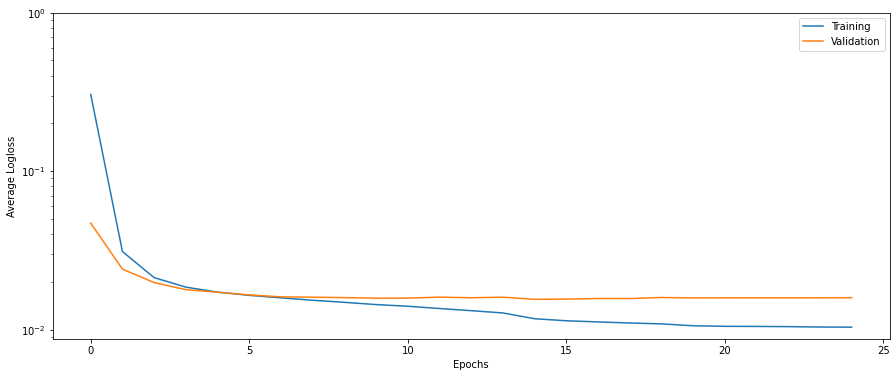

In [13]:
# Show Model loss in plots

for k,v in historys.items():
    loss = []
    val_loss = []
    loss.append(v.history['loss'][:40])
    val_loss.append(v.history['val_loss'][:40])
    
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 6))
plt.plot(np.mean(loss, axis=0))
plt.plot(np.mean(val_loss, axis=0))
plt.yscale('log')
plt.yticks(ticks=[1,1e-1,1e-2])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [14]:
print(f'OOF Metric (relu): {metric(train_targets, res_relu)}')
print(f'OOF Metric (elu): {metric(train_targets, res_elu)}')

OOF Metric (relu): 0.015063118721781189
OOF Metric (elu): 0.015084917819819212


In [15]:
ss_relu.to_csv('submission_relu.csv', index=False)
ss_elu.to_csv('submission_elu.csv', index=False)

Kernel still under modification.. **<span style='color:red'>Feedbacks</span>** is also very much appreciated.
Pls **<span style='color:red'>UPVOTE</span>**, if you find it useful. 
